# Dataset generators

In this advanced tutorials I demonstrate an efficient way of using the TensorFlow [tf.Data API](https://www.tensorflow.org/guide/data) to create a dataset. This approach has some important advantages:

1. It provides a lot of flexibility in terms of using Python and packages such as NumPy to create a dataset.
2. By working with large databases, you can call the samples and shuffling **on-demand** which significantly reduce memory usage. In fact, memory won't be a bottleneck anymore. 

This will be done by [Python generator functions](https://www.tensorflow.org/guide/data#consuming_python_generators) to create [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects. The process is as follows:

1. By using a generator function, we dictate the way data must be generated.
2. By using [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method, we create the TensorFlow dataset.

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Preprocessing
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add one domention to make 3D images
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

# Track the data type
dataType, dataShape = x_train.dtype, x_train.shape
print(f"Data type and shape x_train: {dataType} {dataShape}")
labelType, labelShape = y_train.dtype, y_train.shape
print(f"Data type and shape y_train: {labelType} {labelShape}")

Data type and shape x_train: float64 (60000, 28, 28, 1)
Data type and shape y_train: uint8 (60000,)


## Generators

Here, I define separate generators for train/test. The generator function, pick a random sample from the dataset at each step. This create a shuffled dataset without the need to use the [.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method. Sometimes [.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method can be very [memory consuming](https://www.tensorflow.org/guide/data_performance#reducing_memory_footprint).

In [3]:
# Defining generator functions for train/test samples
TRAIN_LEN = x_train.shape[0]
def gen_pairs_train():
    for i in range(TRAIN_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TRAIN_LEN)
        yield (x_train[idx], y_train[idx])


TEST_LEN = x_test.shape[0]
def gen_pairs_test():
    for i in range(TEST_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TEST_LEN)
        yield (x_test[idx], y_test[idx])

# Function to test input pipeline
sample_image, sample_label = next(gen_pairs_train())

## Dataset creation

Here I just used tf.data.Dataset.from_generator on top of the *gen_pairs_train()* and *gen_pairs_test()* generator functions.

In [4]:
batch_size = 32
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_train, output_types=(tf.float64, tf.uint8))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_test, output_types=(tf.float64, tf.uint8))
test_dataset = test_dataset.batch(batch_size)

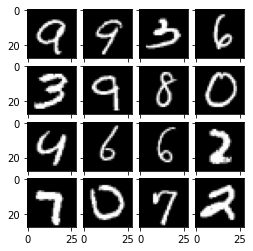

In [5]:
im_list = []
n_samples_to_show = 16
c = 0
for i in range(n_samples_to_show):
  img, label = next(gen_pairs_train())
  im_list.append(img)
# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(4., 4.))
# Ref: https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
# Show image grid
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[:,:,0], 'gray')
plt.show()

In [6]:
# Model building
NUM_CLASSES = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')]
    )

In [7]:
# Defining loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy_metric = tf.keras.metrics.Accuracy()

# Calculate loss
def loss_fn(gt_label, pred):
  # training argument define the beehaviour of layers with respect
  # to whether we are training the model or not. It is important for layers
  # such as BatchNorm and Dropout.
  return loss_object(y_true=gt_label, y_pred=pred)

def accuracy_fn(gt_label, output):
  # calculate the accuracy by turning output into labels with argmax
  pred = tf.argmax(output, axis=1, output_type=tf.int32)
  return accuracy_metric(pred, gt_label)


In [8]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [9]:
NUM_EPOCHS = 5
EPOCH_PER_DISPLAY = 1
total_loss = []
for epoch in range(NUM_EPOCHS):

  running_loss = []
  running_accuracy = []

  # Training
  for input, target in train_dataset:

    # Calculate and track graduents
    with tf.GradientTape() as tape:

      # Calculate model output and loss
      output = model(input, training=True)
      loss_ = loss_fn(target, output)
      accuracy_ = accuracy_fn(target, output)
      
      # Tape gradients
      grads = tape.gradient(loss_, model.trainable_variables)
      
    # Track batch loss and accuracy
    running_loss.append(loss_)
    running_accuracy.append(accuracy_)

    # Optimize model based on the gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  # Epoch calculations
  epoch_loss = np.mean(running_loss)
  epoch_accuracy = np.mean(running_accuracy)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Loss: {:.4f} Accuracy: {:.2f}%".format(epoch+1, epoch_loss, epoch_accuracy * 100))


Epoch 1: Loss: 0.1329 Accuracy: 92.25%
Epoch 2: Loss: 0.0746 Accuracy: 96.68%
Epoch 3: Loss: 0.0679 Accuracy: 97.26%
Epoch 4: Loss: 0.0649 Accuracy: 97.58%
Epoch 5: Loss: 0.0695 Accuracy: 97.79%


In [10]:
# Calculate the accurcy on the test set
running_accuracy = []
for (input, gt_label) in test_dataset:
  output = model(input, training=False)
  accuracy_ = accuracy_fn(gt_label, output)
  running_accuracy.append(accuracy_)

print("Test accuracy: {:.3%}".format(np.mean(running_accuracy)))


Test accuracy: 97.881%
